In [2]:
#Conda env: py_3916

#Import packages
#---------------------------------------
import sys
from matplotlib import pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns


#Import your modules
#---------------------------------------
import plaque_f as pf

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'
s_fig = '/cndd3/dburrows/FIGS/'

%load_ext autoreload
sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) \n[GCC 9.4.0]'

# Load data

In [3]:
def run_(long_name, short_name):
    # Declare paths
    data_path = s_data + 'spatial_transcriptomics/plaques/' + long_name + '.json'
    coord_path = '/cndd2/agelber/hal/qc_aligned/' + short_name + '/outs/spatial/tissue_positions.csv'
    genes_path = '/cndd2/agelber/hal/qc_aligned/' + short_name + '/outs/filtered_feature_bc_matrix.h5'
    meta = pd.read_csv('/home/AD/agelber/desp1/precast/prec_c25q25g3000/qc_cell_annotation.csv')
    meta_filt = meta[meta['sample'] == short_name]

    spot_df, gene_df = pf.sort_data(data_path, coord_path, genes_path, 
                                    meta_filt, min_cell_per_gene=0)#, norm_factor=1e6)
    
    #Sanity check
    assert spot_df.shape[0] == gene_df.shape[0] == meta_filt.shape[0]
    #assert 'Thy1' not in gene_df.columns.values or 'humanAPP' not in gene_df.columns.values
    print('Number of spots: ' + str(gene_df.shape[0]))
    print('Number of genes: ' + str(gene_df.shape[1]))
    return(spot_df, gene_df)

In [380]:
name = '030-D'
spot_df, gene_df = run_(name)

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Number of spots: 3382
Number of genes: 13185


In [382]:
spot_df
gene_df

,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Rb1cc1,St18,Pcmtd1,...,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,Spry3,Tmlhe,AC149090.1
AAACAAGTATCTCCCA-1,214.9151,0.000000,0.000000,71.638367,214.915100,429.830200,0.000000,0.000000,0.000000,71.638367,...,573.106934,18984.167969,3008.811523,71.638367,22924.277344,0.0,0.000000,0.000000,0.000000,143.276733
AAACAATCTACTAGCA-1,0.0000,0.000000,0.000000,0.000000,0.000000,158.906723,0.000000,0.000000,317.813446,158.906723,...,158.906723,8422.056641,1271.253784,158.906723,12076.911133,0.0,0.000000,0.000000,0.000000,0.000000
AAACAGAGCGACTCCT-1,0.0000,0.000000,0.000000,0.000000,0.000000,235.478806,0.000000,0.000000,0.000000,0.000000,...,1255.886963,28492.935547,2747.252686,235.478806,30847.722656,0.0,0.000000,0.000000,0.000000,156.985870
AAACAGTGTTCCTGGG-1,0.0000,0.000000,35.880875,0.000000,35.880875,215.285248,0.000000,35.880875,0.000000,143.523499,...,502.332245,19949.765625,2870.469971,35.880875,20452.097656,0.0,35.880875,35.880875,0.000000,287.046997
AAACATTTCCCGGATT-1,0.0000,96.547470,38.618988,57.928482,19.309494,193.094940,19.309494,96.547470,0.000000,154.475952,...,77.237976,4383.255371,617.903809,38.618988,6082.490723,0.0,77.237976,19.309494,0.000000,386.189880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,0.0000,73.686539,36.843269,110.529808,36.843269,257.902893,0.000000,0.000000,0.000000,73.686539,...,184.216339,8916.071289,1289.514404,73.686539,12931.987305,0.0,36.843269,0.000000,0.000000,257.902893
TTGTTTCATTAGTCTA-1,0.0000,0.000000,38.908993,38.908993,77.817986,194.544968,0.000000,0.000000,0.000000,116.726974,...,194.544968,10855.609375,1283.996704,38.908993,12606.513672,0.0,38.908993,0.000000,38.908993,311.271942
TTGTTTCCATACAACT-1,0.0000,68.189560,113.649277,45.459709,22.729855,113.649277,22.729855,90.919418,0.000000,68.189560,...,204.568695,11637.685547,1545.630127,22.729855,14319.808594,0.0,45.459709,0.000000,0.000000,181.838837
TTGTTTGTATTACACG-1,0.0000,0.000000,0.000000,58.414627,0.000000,175.243881,0.000000,0.000000,0.000000,175.243881,...,700.975525,24183.656250,3329.633789,116.829254,24358.900391,0.0,0.000000,0.000000,0.000000,116.829254


# Visualise plaques



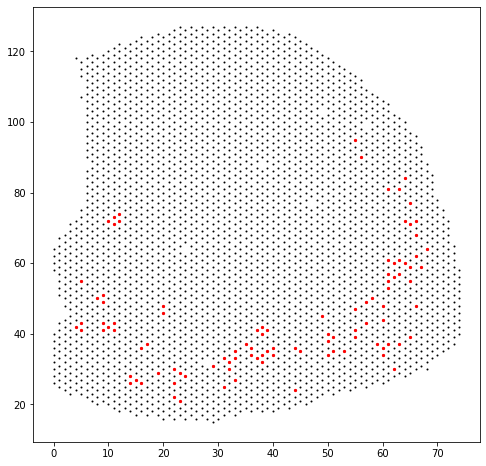

In [383]:
#PLOT PLAQUES
fig = plt.figure(figsize=(8,8))
xcoord, ycoord = spot_df['array_row'].values, spot_df['array_col'].values
plq_bool = spot_df['plaque'].values == 1

plt.scatter(xcoord, ycoord, s=1, c='k')
plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=5, c='red')
plt.show()

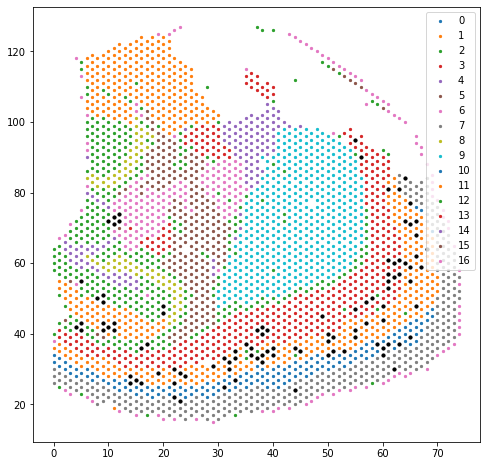

In [384]:

fig = plt.figure(figsize=(8,8))
clust_lab = spot_df['cluster'].values

for x in range(len(np.unique(clust_lab))): 
    plt.scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=5, label = str(x))
plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
plt.legend()
#plt.savefig('fig_dump/plaque-clusters-01.svg', transparent=True)
plt.show()


In [390]:
clust_lab

array([17, 12,  2, ...,  7,  7,  2])

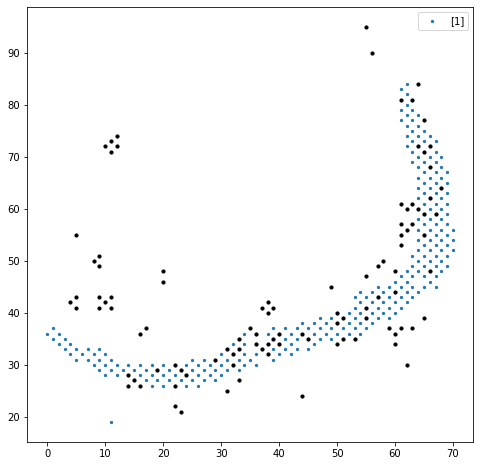

In [393]:
x=[1]
fig = plt.figure(figsize=(8,8))
plt.scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=5, label = str(x))
plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
plt.legend()
#plt.savefig('fig_dump/plaque-clusters-01.svg', transparent=True)
plt.show()


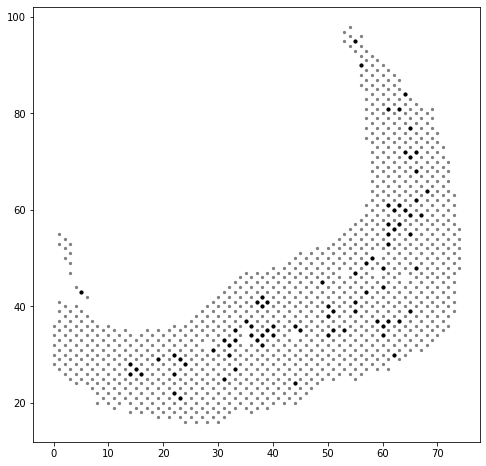

In [100]:
#Cortex plaques
cort_l = [3,6,8,9]

fig = plt.figure(figsize=(8,8))
for x in range(len(np.unique(clust_df['cluster']))): 
    if x in cort_l:
        plt.scatter(rows[row_ind[x]], cols[row_ind[x]], s=5, label = str(x), c = 'grey')
        plt.scatter(rows[np.intersect1d(np.where(plq_bool == True)[0], row_ind[x])], cols[np.intersect1d(np.where(plq_bool == True)[0], row_ind[x])], s=10, c='k')
#plt.savefig('fig_dump/plaque-clusters-cortex-01.svg', transparent=True)
plt.show()


# Plaque distribution 


In [4]:
#sort out names
import glob
import os
os.chdir('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/')
og = glob.glob('*.json')
ID = [i.split('.')[0] for i in og]
sub_ID=[]
for x,i in enumerate(og):
    if x != 5: sub_ID = np.append(sub_ID, i.split('_')[1][:-5])
    else: sub_ID = np.append(sub_ID, i[:-5])
ID, sub_ID


(['V11Y17_109-D',
  'V11Y10_030-C',
  'S29_030-D',
  'V11Y17_109-A',
  'V10S15_040-C',
  '030-B',
  'V11Y17_109-C',
  'V10S15_040-A',
  'V10S15_040-D'],
 array(['109-D', '030-C', '030-D', '109-A', '040-C', '030-B', '109-C',
        '040-A', '040-D'], dtype='<U32'))

In [15]:
#Define colormap by clusters
col_df = pd.read_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/colors.csv')
sort_clust = col_df['cluster_order'] #all clusters sorted 
sort_col = col_df['color']


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2959
Number of genes: 32284


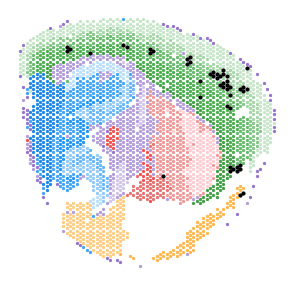

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3397
Number of genes: 32284


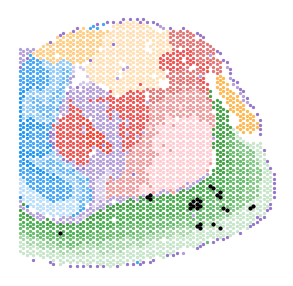

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2998
Number of genes: 32284


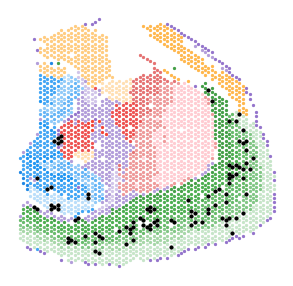

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3204
Number of genes: 32284


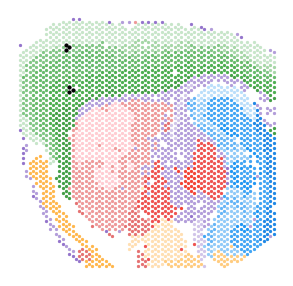

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3406
Number of genes: 32284


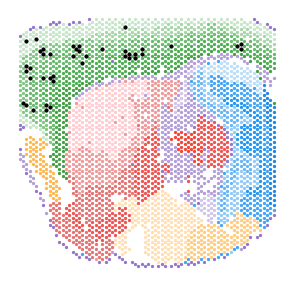

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2835
Number of genes: 32284


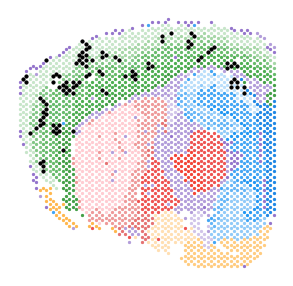

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3002
Number of genes: 32284


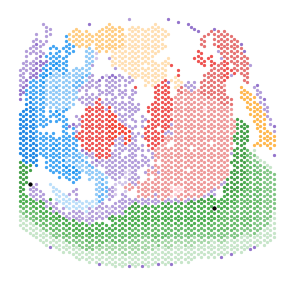

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3343
Number of genes: 32284


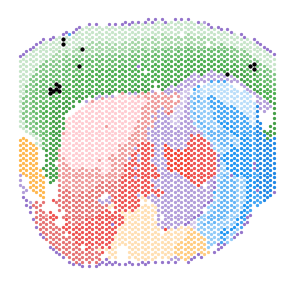

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3285
Number of genes: 32284


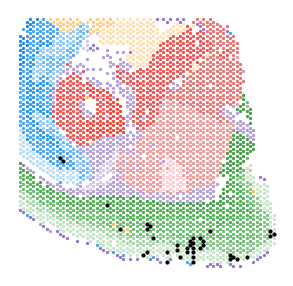

In [145]:

#plot and save all samples
for y,name in enumerate(sub_ID):
    spot_df, gene_df = run_(ID[y], sub_ID[y])
    clust_lab = spot_df['cluster'].values
    xcoord, ycoord = spot_df['array_row'].values, spot_df['array_col'].values
    plq_bool = spot_df['plaque'].values == 1


    fig,ax = plt.subplots(figsize=(5,5))
    for x in range(len(sort_clust)): 
        plt.scatter(xcoord[np.where(clust_lab==sort_clust[x])[0]], ycoord[np.where(clust_lab==sort_clust[x])[0]], s=5, label = sort_clust[x], color = sort_col[x], alpha=1)
    plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, markerscale=2)

    #remove all borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

    plt.savefig(s_fig + 'plaque-clusters-' + sub_ID[y] + '.svg', transparent=True)
    plt.show()


In [6]:
#Look at distribution of plaques across clusters
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()
for x,name in enumerate(sub_ID):
    spot_df, gene_df = run_(ID[x], sub_ID[x])
    cat_df = pd.concat([cat_df, spot_df])

clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']
# clust_df['region'] = cat_df.groupby('cluster').sum()['plaque'].index.values
clust_df['total spots'] = cat_df.groupby('cluster').count()['plaque']
clust_df['percent of spots'] = clust_df['plaque']/clust_df['total spots'] *100
clust_df['percent of spots'] = clust_df['percent of spots'].round(2)
clust_df['percent of all plaques'] = clust_df['plaque']/clust_df['plaque'].sum() *100
clust_df['percent of all plaques'] = clust_df['percent of all plaques'].round(2)

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2959
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3397
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2998
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3204
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3406
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2835
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3002
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3343
Number of genes: 32284


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3285
Number of genes: 32284


<ipython-input-6-597a0b1a0477>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']


In [8]:
col_df

,cluster_order,color
0,Cortex Layer 2/3,#C7E5C9FF
1,Cortex Layer 4,#A5D6A6FF
2,Cortex Layer 5a,#80C684FF
3,Cortex Layer 5b,#66BA6AFF
4,Cortex Layer 6a,#4CAE50FF
5,"CTXsp (L6b, CLA, EP)",#439F46FF
6,CA1,#BADEFAFF
7,CA3-so/sr,#90CAF8FF
8,CA3-sp,#64B4F6FF
9,Dentate Gyrus-mo,#41A5F4FF


In [ ]:
df['m'] = pd.Categorical(df['m'], ["March", "April", "Dec"])

In [7]:
clust_df

,plaque,total spots,percent of spots,percent of all plaques
cluster,,,,
Amygdala,0,1142,0.00,0.00
CA1,13,518,2.51,3.41
CA3-so/sr,1,1102,0.09,0.26
CA3-sp,0,549,0.00,0.00
COAa,0,1219,0.00,0.00
COAp,0,941,0.00,0.00
"CTXsp (L6b, CLA, EP)",8,1155,0.69,2.10
Caudoputamen,0,1763,0.00,0.00
Cortex Layer 2/3,56,2372,2.36,14.70


In [12]:
clust_df.index

Index(['Amygdala', 'CA1', 'CA3-so/sr', 'CA3-sp', 'COAa', 'COAp',
       'CTXsp (L6b, CLA, EP)', 'Caudoputamen', 'Cortex Layer 2/3',
       'Cortex Layer 4', 'Cortex Layer 5a', 'Cortex Layer 5b',
       'Cortex Layer 6a', 'Dentate Gyrus-mo', 'Dentate Gyrus-sg',
       'Fiber Tracts', 'GP/TH', 'Lateral Venticle', 'Meninges',
       'Piriform Cortex', 'RHP', 'Reticular Nucleus', 'STRv'],
      dtype='object', name='cluster')

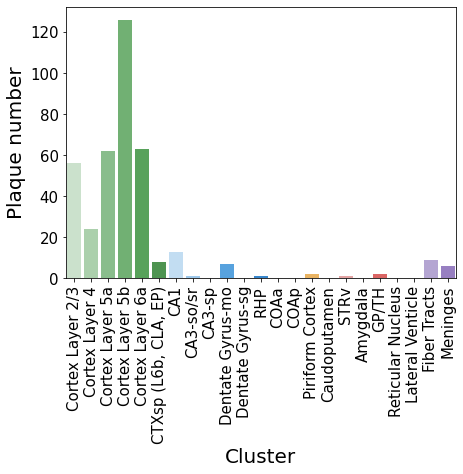

In [19]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(clust_df, x=clust_df.index, y= "plaque", palette=sort_col, order=sort_clust) 
#label x axis
plt.ylabel('Plaque number', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_fig + 'plaque-clusters-barplot.svg', transparent=True)
plt.show()

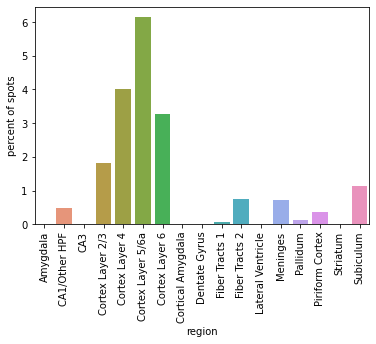

In [105]:
sns.barplot(clust_df, x='region', y= "percent of spots", order=clust_df.sort_values('region', ascending=True).region)# hue="sex", stat="probability", multiple="fill", shrink=.8)
plt.xticks(rotation=90)
plt.show()

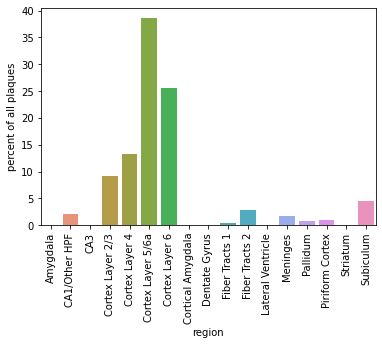

In [106]:
sns.barplot(clust_df, x='region', y= "percent of all plaques", order=clust_df.sort_values('region', ascending=True).region)# hue="sex", stat="probability", multiple="fill", shrink=.8)
plt.xticks(rotation=90)
plt.show()

In [292]:
cat_df

,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,plaque,cluster,anot
114443,AAACAATCTACTAGCA-1,1,3,43,1036,506,0,7,Cortex Layer 2/3
114444,AAACACCAATAACTGC-1,1,59,19,1290,1553,0,8,CA3
114445,AAACAGCTTTCAGAAG-1,1,43,9,1399,1255,0,13,Cortical Amygdala
114446,AAACAGGGTCTATATT-1,1,47,13,1355,1329,0,13,Cortical Amygdala
114447,AAACAGTGTTCCTGGG-1,1,73,43,1032,1814,0,16,Meninges
...,...,...,...,...,...,...,...,...,...
138352,TTGTTTCACATCCAGG-1,1,58,42,1048,1875,0,3,Cortex Layer 6
138353,TTGTTTCATTAGTCTA-1,1,60,30,1175,1912,0,1,Cortex Layer 5/6a
138354,TTGTTTCCATACAACT-1,1,45,27,1207,1636,0,7,Cortex Layer 2/3
138355,TTGTTTGTATTACACG-1,1,73,41,1057,2151,0,1,Cortex Layer 5/6a


In [299]:
#Look at distribution of spots across sample
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()
for x,name in enumerate(sub_ID):
    spot_df, gene_df = run_ID(ID[x], sub_ID[x])
    spot_df['sample id'] = np.full(len(spot_df), name)
    cat_df = pd.concat([cat_df, spot_df])

cat_filt = cat_df[cat_df['plaque'] == 1]
cat_filt

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2939
Number of genes: 12404


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3532
Number of genes: 12921


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Number of spots: 3382
Number of genes: 13185


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3465
Number of genes: 13268


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3616
Number of genes: 13343


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3457
Number of genes: 13096


In [374]:
cat_df.groupby('cluster').first()['anot'], col_v

(cluster
 1     Cortex Layer 5/6a
 2         CA1/Other HPF
 3        Cortex Layer 6
 4         Dentate Gyrus
 5        Fiber Tracts 1
 6              Pallidum
 7      Cortex Layer 2/3
 8                   CA3
 9              Striatum
 10       Cortex Layer 4
 11            Subiculum
 12       Fiber Tracts 2
 13    Cortical Amygdala
 14             Amygdala
 15    Lateral Ventricle
 16             Meninges
 17      Piriform Cortex
 Name: anot, dtype: object,
 [(0.4784529411764706, 0.0, 0.5450705882352941, 1.0),
  (0.3450764705882353, 0.0, 0.6235411764705882, 1.0),
  (0.0, 0.0, 0.7725823529411764, 1.0),
  (0.0, 0.329435294117647, 0.8667, 1.0),
  (0.0, 0.5843176470588236, 0.8667, 1.0),
  (0.0, 0.6667, 0.6588529411764706, 1.0),
  (0.0, 0.6510058823529412, 0.40781764705882395, 1.0),
  (0.0, 0.6548882352941175, 0.0, 1.0),
  (0.0, 0.811770588235294, 0.0, 1.0),
  (0.0, 0.9686352941176471, 0.0, 1.0),
  (0.6901647058823523, 1.0, 0.0, 1.0),
  (0.9411470588235293, 0.9176176470588236, 0.0, 1.0),
  

In [360]:

new_col = [cmap(i+1) for i in np.unique(cat_filt[''])]
new_col

[(0.3450764705882353, 0.0, 0.6235411764705882, 1.0),
 (0.0, 0.0, 0.7725823529411764, 1.0),
 (0.0, 0.329435294117647, 0.8667, 1.0),
 (0.0, 0.6667, 0.6588529411764706, 1.0),
 (0.0, 0.6510058823529412, 0.40781764705882395, 1.0),
 (0.0, 0.6548882352941175, 0.0, 1.0),
 (0.6901647058823523, 1.0, 0.0, 1.0),
 (0.9411470588235293, 0.9176176470588236, 0.0, 1.0),
 (1.0, 0.7411764705882354, 0.0, 1.0),
 (0.8, 0.8, 0.8, 1.0),
 (0.8, 0.8, 0.8, 1.0)]

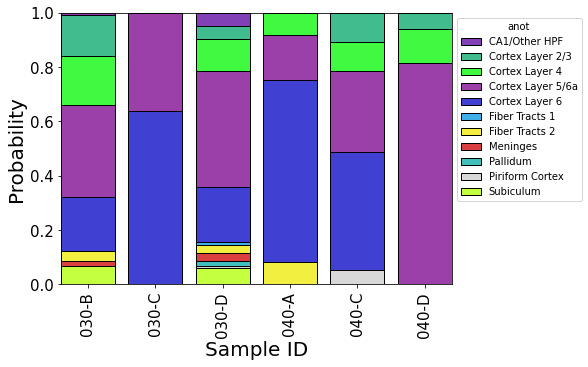

In [390]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(cat_filt, x="sample id", hue="anot", hue_order = np.unique(cat_filt['anot']),palette=new_ord_col, stat='probability', multiple="fill", shrink=.8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Sample ID', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_fig + 'plaque-clusters-propplot.svg', transparent=True)
plt.show()

# Compare adjacent slices for gene expression

In [78]:
og_df, og_gene_df = run_('030-B')
clust_lab = og_df['cluster'].values
reg_lab = np.asarray(og_df.groupby('cluster').first()['anot'])

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2939
Number of genes: 12404


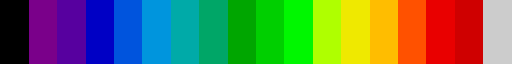

In [79]:
#Choose colormap
cmap = plt.get_cmap("nipy_spectral", len(np.unique(reg_lab))+1)
cmap

In [80]:
name = '030-B'
data_path = s_data + 'spatial_transcriptomics/plaques/' + name + 'X.json'
coord_path = '/cndd2/agelber/hal/qc_aligned/' + name + '/outs/spatial/tissue_positions.csv'
genes_path = '/cndd2/agelber/hal/qc_aligned/' + name + '/outs/filtered_feature_bc_matrix.h5'
meta = pd.read_csv('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/allspots_meta.csv') #FILTERED
meta_filt = meta[meta['sample'] == name]

spot_df, gene_df = pf.sort_data(data_path, coord_path, genes_path, 
                                meta_filt, min_cell_per_gene=100, norm_factor=1e6)

#Sanity check
assert spot_df.shape[0] == gene_df.shape[0] == meta_filt.shape[0]
assert 'Thy1' not in gene_df.columns.values or 'humanAPP' not in gene_df.columns.values
print('Number of spots: ' + str(gene_df.shape[0]))
print('Number of genes: ' + str(gene_df.shape[1]))

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2939
Number of genes: 12404


In [58]:
#plot and save all samples

xcoord, ycoord = spot_df['array_row'].values, spot_df['array_col'].values
plq_bool = spot_df['plaque'].values == 1


fig,ax = plt.subplots(figsize=(5,5))
for x in range(len(np.unique(clust_lab))): 
    plt.scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=5, label = reg_lab[x], color = cmap(x+1), alpha=1)
plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, markerscale=2)

#remove all borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

plt.savefig(s_fig + 'plaque-clusters-' + name + '.svg', transparent=True)
plt.show()


(2939,)

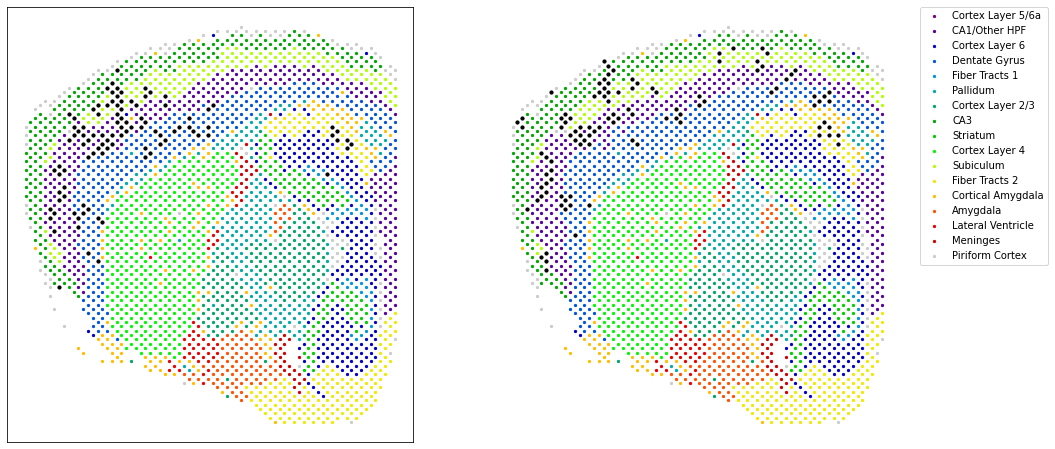

In [84]:
#PLOT PLAQUES
data_l = og_df, spot_df
fig,ax = plt.subplots(1, 2, figsize=(16,8))

for i,data in enumerate(data_l):
    xcoord, ycoord = data['array_row'].values, data['array_col'].values
    plq_bool = data['plaque'].values == 1
    clust_lab = data['cluster'].values
    for x in range(len(np.unique(clust_lab))): 
        ax[i].scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=5, label = reg_lab[x], color = cmap(x+1), alpha=1)
    ax[i].scatter(xcoord[plq_bool], ycoord[plq_bool], s=10, c='k')
    ax[i].xaxis.set_tick_params(labelbottom=False)
    ax[i].yaxis.set_tick_params(labelleft=False)
    ax[i].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [127]:
#original ordering of cluster
col_ord = og_df.groupby('cluster').first()['anot']

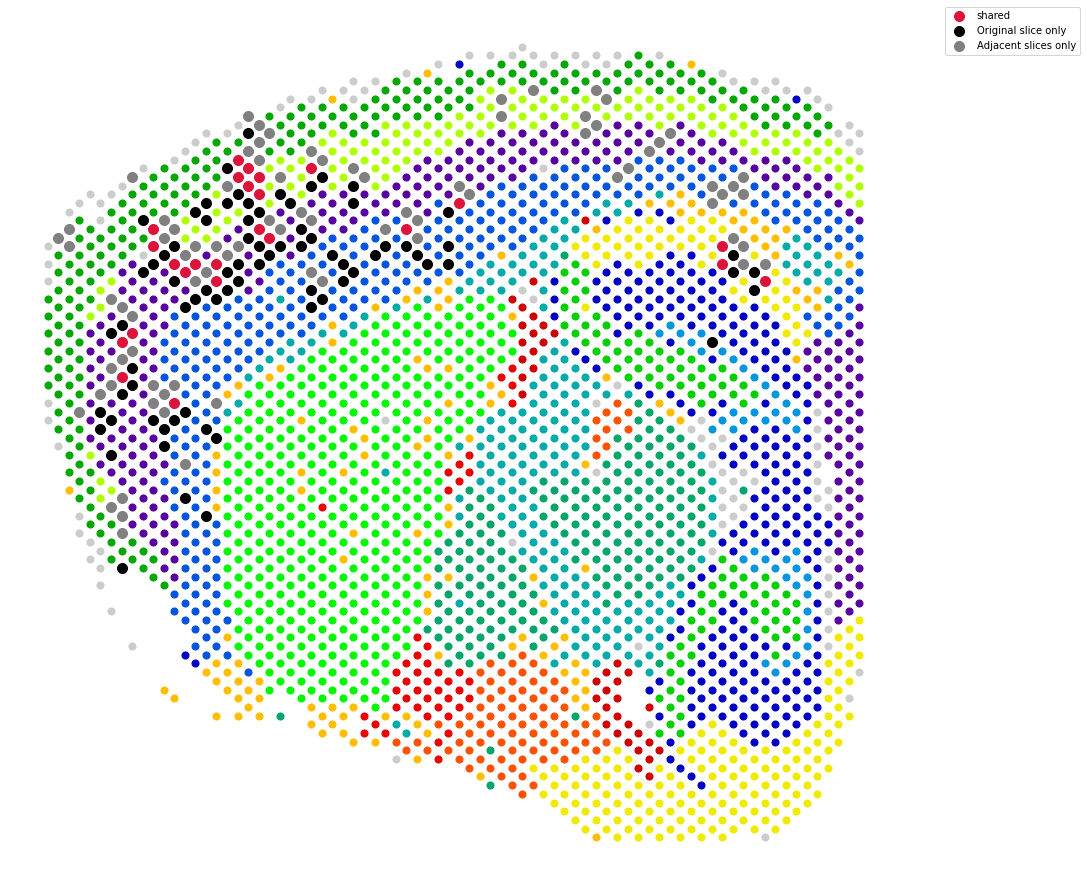

In [553]:
#PLOT OVERLAPPING PLAQUES
og_plq = np.where(og_df['plaque']==1)[0]
new_plq = np.where(spot_df['plaque']==1)[0]
shared = np.intersect1d(og_plq, new_plq)
og_notin = np.setxor1d(og_plq, shared)
new_notin = np.setxor1d(new_plq, shared)

assert len(og_plq) == len(og_notin) + len(shared)
assert len(new_plq) == len(new_notin) + len(shared)
data = og_df

fig,ax = plt.subplots(figsize=(16,16))
xcoord, ycoord = data['array_row'].values, data['array_col'].values
plq_bool = data['plaque'].values == 1
clust_lab = data['cluster'].values
for x in range(len(np.unique(clust_lab))): 
    plt.scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=50, color = cmap(x+1), alpha=1)

plt.scatter(xcoord[shared], ycoord[shared], s=100, c='crimson', label='shared')
plt.scatter(xcoord[og_notin], ycoord[og_notin], s=100, c='k', label='Original slice only')
plt.scatter(xcoord[new_notin], ycoord[new_notin], s=100, c='grey', label='Adjacent slices only')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig(s_fig + 'plaque-overlap.svg', transparent=True)
plt.show()


In [341]:
cort_l = 'Cortex Layer 2/3', 'Cortex Layer 4', 'Cortex Layer 5/6a', 'Cortex Layer 6'

In [433]:
cort_l

('Cortex Layer 2/3', 'Cortex Layer 4', 'Cortex Layer 5/6a', 'Cortex Layer 6')

In [435]:
clust_lab

array(['Cortex Layer 2/3', 'CA3', 'Cortical Amygdala', ..., 'Pallidum',
       'Meninges', 'Cortex Layer 5/6a'], dtype=object)

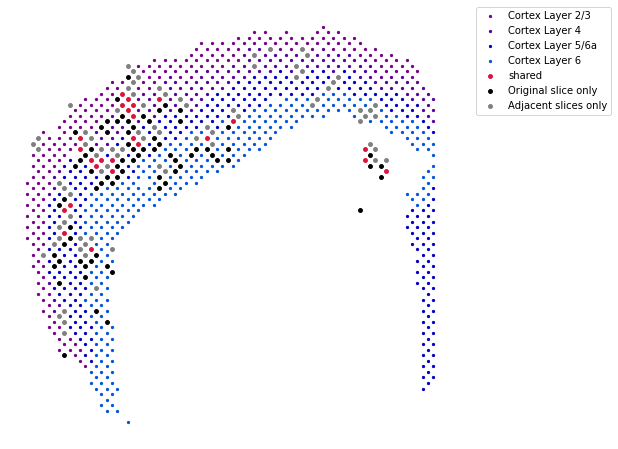

In [436]:
#PLOT OVERLAPPING PLAQUES
og_plq = np.where(og_df['plaque']==1)[0]
new_plq = np.where(spot_df['plaque']==1)[0]
shared = np.intersect1d(og_plq, new_plq)
og_notin = np.setxor1d(og_plq, shared)
new_notin = np.setxor1d(new_plq, shared)

assert len(og_plq) == len(og_notin) + len(shared)
assert len(new_plq) == len(new_notin) + len(shared)
data = og_df

fig,ax = plt.subplots(figsize=(8,8))
xcoord, ycoord = data['array_row'].values, data['array_col'].values
plq_bool = data['plaque'].values == 1
clust_lab = data['anot'].values
for y,x in enumerate(cort_l):
    plt.scatter(xcoord[np.where(clust_lab==x)[0]], ycoord[np.where(clust_lab==x)[0]], s=5, label = x, color = cmap(y+1), alpha=1)

plt.scatter(xcoord[shared], ycoord[shared], s=15, c='crimson', label='shared')
plt.scatter(xcoord[og_notin], ycoord[og_notin], s=15, c='k', label='Original slice only')
plt.scatter(xcoord[new_notin], ycoord[new_notin], s=15, c='grey', label='Adjacent slices only')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [137]:
new_ord_col = [col_v[np.where(np.unique(cat_filt['anot'])[i] == col_ord)[0][0]] for i in range(len(np.unique(cat_filt['anot'])))]
new_ord_col

[(0.0, 0.6510058823529412, 0.40781764705882395, 1.0),
 (0.0, 0.9686352941176471, 0.0, 1.0),
 (0.4784529411764706, 0.0, 0.5450705882352941, 1.0),
 (0.0, 0.0, 0.7725823529411764, 1.0),
 (0.9411470588235293, 0.9176176470588236, 0.0, 1.0),
 (0.6901647058823523, 1.0, 0.0, 1.0)]

<ipython-input-554-ed3b8b8a1c29>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']


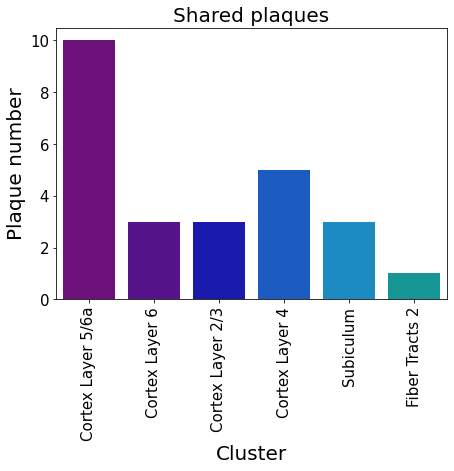

In [554]:
#Look at distribution of plaques across clusters
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()

cat_df = og_df.iloc[shared]
clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']
clust_df['region'] = cat_df.groupby('cluster').first()['anot']
clust_df['total spots'] = cat_df.groupby('cluster').count()['plaque']
clust_df['percent of spots'] = clust_df['plaque']/clust_df['total spots'] *100
clust_df['percent of spots'] = clust_df['percent of spots'].round(2)
clust_df['percent of all plaques'] = clust_df['plaque']/clust_df['plaque'].sum() *100
clust_df['percent of all plaques'] = clust_df['percent of all plaques'].round(2)


fig, ax = plt.subplots(figsize=(7,5))
plt.title('Shared plaques', fontsize=20)
sns.barplot(clust_df, x='region', y= "plaque", palette=col_v)# order=clust_df.sort_values('region', ascending=True).region, palette=z) 
#label x axis
plt.ylabel('Plaque number', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_fig + 'plaque-overlap-barplot.svg', transparent=True)
plt.show()

<ipython-input-555-27b705883cfc>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']


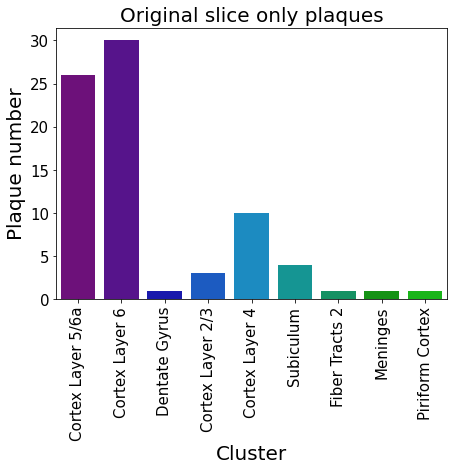

In [555]:
#Look at distribution of plaques across clusters
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()

cat_df = og_df.iloc[og_notin]
clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']
clust_df['region'] = cat_df.groupby('cluster').first()['anot']
clust_df['total spots'] = cat_df.groupby('cluster').count()['plaque']
clust_df['percent of spots'] = clust_df['plaque']/clust_df['total spots'] *100
clust_df['percent of spots'] = clust_df['percent of spots'].round(2)
clust_df['percent of all plaques'] = clust_df['plaque']/clust_df['plaque'].sum() *100
clust_df['percent of all plaques'] = clust_df['percent of all plaques'].round(2)

fig, ax = plt.subplots(figsize=(7,5))
plt.title('Original slice only plaques', fontsize=20)
sns.barplot(clust_df, x='region', y= "plaque",palette=col_v)# order=clust_df.sort_values('region', ascending=True).region, palette=z) 
#label x axis
plt.ylabel('Plaque number', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_fig + 'plaque-sliceonly-barplot.svg', transparent=True)
plt.show()

<ipython-input-556-f1dee2f2b8ed>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']


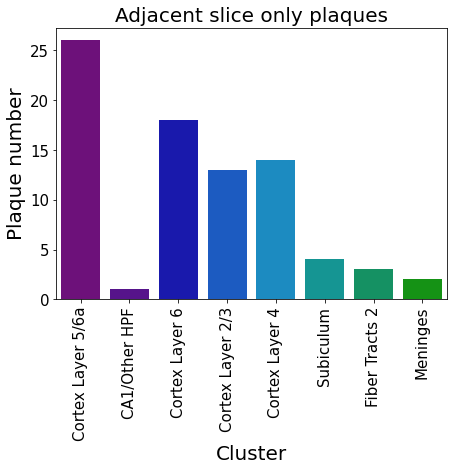

In [556]:
#Look at distribution of plaques across clusters
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()

cat_df = spot_df.iloc[new_notin]
clust_df['plaque'] = cat_df.groupby('cluster').sum()['plaque']
clust_df['region'] = cat_df.groupby('cluster').first()['anot']
clust_df['total spots'] = cat_df.groupby('cluster').count()['plaque']
clust_df['percent of spots'] = clust_df['plaque']/clust_df['total spots'] *100
clust_df['percent of spots'] = clust_df['percent of spots'].round(2)
clust_df['percent of all plaques'] = clust_df['plaque']/clust_df['plaque'].sum() *100
clust_df['percent of all plaques'] = clust_df['percent of all plaques'].round(2)

fig, ax = plt.subplots(figsize=(7,5))
plt.title('Adjacent slice only plaques', fontsize=20)
sns.barplot(clust_df, x='region', y= "plaque",palette=col_v)# order=clust_df.sort_values('region', ascending=True).region, palette=z) 
#label x axis
plt.ylabel('Plaque number', fontsize=20)
plt.xlabel('Cluster', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(s_fig + 'plaque-adjacentonly-barplot.svg', transparent=True)
plt.show()

In [144]:
#Look at distribution of spots across sample
#-----------------------------------------------
cat_df=pd.DataFrame()
clust_df=pd.DataFrame()
data_l = og_df, spot_df
name_l = 'Original', 'Adjacent'

for x,data in enumerate(data_l):
    data['sample id'] = np.full(len(data), name_l[x])
    cat_df = pd.concat([cat_df, data])


In [145]:
cat_filt = cat_df[cat_df['plaque'] == 1]
cat_filt

,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,plaque,cluster,anot,sample id
114462,AAAGACCCAAGTCGCG-1,1,10,48,982,637,1,3,Cortex Layer 6,Original
114490,AACACGACTGTACTGA-1,1,9,65,799,617,1,1,Cortex Layer 5/6a,Original
114505,AACCGAGCTTGGTCAT-1,1,24,70,745,897,1,1,Cortex Layer 5/6a,Original
114506,AACCGTTGTGTTTGCT-1,1,12,64,810,674,1,1,Cortex Layer 5/6a,Original
114526,AACTGATATTAGGCCT-1,1,16,66,788,748,1,1,Cortex Layer 5/6a,Original
...,...,...,...,...,...,...,...,...,...,...
117236,TTATATTTGGCAATCC-1,1,26,64,809,935,1,3,Cortex Layer 6,Adjacent
117261,TTCATGGCGCAACAGG-1,1,19,75,691,804,1,10,Cortex Layer 4,Adjacent
117301,TTCTTCCCTTTGATAT-1,1,2,70,746,486,1,7,Cortex Layer 2/3,Adjacent
117352,TTGGGAAGACGAGCCG-1,1,68,64,807,1720,1,11,Subiculum,Adjacent


In [121]:
new_ord_col = [col_v[np.where(np.unique(cat_filt['anot'])[i] == cat_df.groupby('cluster').first()['anot'])[0][0]] for i in range(len(np.unique(cat_filt['anot'])))]
new_ord_col

[(0.3450764705882353, 0.0, 0.6235411764705882, 1.0),
 (0.0, 0.6510058823529412, 0.40781764705882395, 1.0),
 (0.0, 0.9686352941176471, 0.0, 1.0),
 (0.4784529411764706, 0.0, 0.5450705882352941, 1.0),
 (0.0, 0.0, 0.7725823529411764, 1.0),
 (0.0, 0.329435294117647, 0.8667, 1.0),
 (0.9411470588235293, 0.9176176470588236, 0.0, 1.0),
 (0.8117705882352941, 0.0, 0.0, 1.0),
 (0.8, 0.8, 0.8, 1.0),
 (0.6901647058823523, 1.0, 0.0, 1.0)]

<ipython-input-557-19a54b62beaa>:2: UserWarning: The palette list has more values (17) than needed (10), which may not be intended.
  sns.histplot(cat_filt, x="sample id", hue="anot", hue_order = np.unique(cat_filt['anot']),palette=col_v, stat='probability', multiple="fill", shrink=.8)


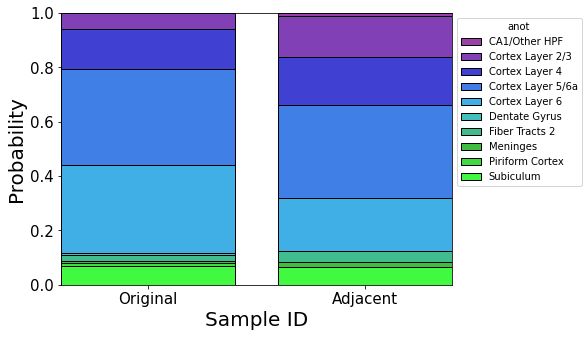

In [557]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(cat_filt, x="sample id", hue="anot", hue_order = np.unique(cat_filt['anot']),palette=col_v, stat='probability', multiple="fill", shrink=.8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Sample ID', fontsize=20)
# change tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=0)
plt.savefig(s_fig + 'plaque-overlap-propplot.svg', transparent=True)
plt.show()


In [169]:
## Correlate gene expression
og_filt = og_gene_df.loc[(og_df['plaque'] == 1).values]
new_filt = gene_df.loc[(spot_df['plaque'] == 1).values]
no_filt = gene_df.loc[(spot_df['plaque'] == 0).values]
og_filt

,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Rb1cc1,St18,Pcmtd1,...,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,Spry3,Tmlhe,AC149090.1
AAAGACCCAAGTCGCG-1,0.0,66.577896,0.000000,199.733688,0.000000,0.000000,0.0,66.577896,0.0,66.577896,...,532.623169,8788.282227,1464.713745,133.155792,14580.559570,0.000000,66.577896,66.577896,0.0,266.311584
AACACGACTGTACTGA-1,0.0,74.537865,74.537865,0.000000,0.000000,0.000000,0.0,74.537865,0.0,0.000000,...,447.227173,17814.548828,2012.522339,74.537865,23703.041016,74.537865,0.000000,0.000000,0.0,149.075729
AACCGAGCTTGGTCAT-1,0.0,0.000000,0.000000,0.000000,0.000000,283.559235,0.0,170.135529,0.0,56.711845,...,283.559235,10378.267578,1587.931641,56.711845,16106.164062,0.000000,56.711845,56.711845,0.0,226.847382
AACCGTTGTGTTTGCT-1,0.0,0.000000,81.294205,0.000000,0.000000,162.588409,0.0,0.000000,0.0,0.000000,...,243.882614,7153.890137,975.530457,0.000000,12681.895508,0.000000,0.000000,0.000000,0.0,0.000000
AACTGATATTAGGCCT-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,192.752502,0.0,64.250832,...,257.003326,13364.172852,1991.775757,0.000000,16319.710938,0.000000,64.250832,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTAATCAGTACGTCAG-1,0.0,63.799919,63.799919,63.799919,127.599838,127.599838,0.0,127.599838,0.0,0.000000,...,255.199677,10016.586914,1594.997925,191.399750,15120.581055,0.000000,63.799919,0.000000,0.0,382.799500
TTCATGGCGCAACAGG-1,0.0,104.047455,34.682484,69.364967,0.000000,208.094910,0.0,0.000000,0.0,173.412415,...,485.554779,14115.770508,1907.536621,34.682484,18208.304688,0.000000,0.000000,0.000000,0.0,277.459869
TTCGGTACTGTAGAGG-1,0.0,0.000000,0.000000,0.000000,0.000000,469.836487,0.0,0.000000,0.0,93.967300,...,375.869202,14283.029297,1597.444092,0.000000,16914.113281,0.000000,93.967300,0.000000,0.0,93.967300
TTGGGAAGACGAGCCG-1,0.0,242.522232,242.522232,161.681488,80.840744,161.681488,0.0,161.681488,0.0,80.840744,...,404.203735,18270.007812,2344.381592,161.681488,21665.320312,0.000000,0.000000,0.000000,0.0,242.522232


In [160]:
new_filt

,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Rb1cc1,St18,Pcmtd1,...,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,Spry3,Tmlhe,AC149090.1
AAAGTCACTGATGTAA-1,0.0,0.000000,55.361790,166.085373,0.000000,55.361790,0.0,166.085373,0.000000,55.361790,...,221.447159,7141.670898,719.703247,110.723579,10961.634766,0.0,0.000000,0.000000,0.0,387.532532
AACTGATATTAGGCCT-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,192.752502,0.000000,64.250832,...,257.003326,13364.172852,1991.775757,0.000000,16319.710938,0.0,64.250832,0.000000,0.0,0.000000
AATCGGGACACTACGA-1,0.0,337.609741,0.000000,0.000000,0.000000,225.073151,0.0,112.536575,0.000000,0.000000,...,225.073151,12379.023438,2025.658325,0.000000,20256.583984,0.0,0.000000,0.000000,0.0,225.073151
AATTCGATTCGAGGAT-1,0.0,0.000000,0.000000,147.666870,0.000000,0.000000,0.0,0.000000,0.000000,147.666870,...,147.666870,10632.014648,1772.002441,147.666870,12256.350586,0.0,147.666870,0.000000,0.0,147.666870
ACACACTTTCTACACG-1,0.0,305.841553,0.000000,0.000000,0.000000,203.894379,0.0,0.000000,0.000000,101.947189,...,203.894379,5097.359375,1019.471924,0.000000,10092.771484,0.0,101.947189,101.947189,0.0,101.947189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTATATTTGGCAATCC-1,0.0,0.000000,0.000000,74.638008,0.000000,74.638008,0.0,0.000000,0.000000,74.638008,...,597.104065,9031.199219,821.018066,74.638008,11792.805664,0.0,0.000000,0.000000,0.0,74.638008
TTCATGGCGCAACAGG-1,0.0,104.047455,34.682484,69.364967,0.000000,208.094910,0.0,0.000000,0.000000,173.412415,...,485.554779,14115.770508,1907.536621,34.682484,18208.304688,0.0,0.000000,0.000000,0.0,277.459869
TTCTTCCCTTTGATAT-1,0.0,0.000000,85.048477,0.000000,0.000000,170.096954,0.0,0.000000,0.000000,85.048477,...,425.242371,11821.738281,1615.921021,85.048477,20921.925781,0.0,0.000000,0.000000,0.0,0.000000
TTGGGAAGACGAGCCG-1,0.0,242.522232,242.522232,161.681488,80.840744,161.681488,0.0,161.681488,0.000000,80.840744,...,404.203735,18270.007812,2344.381592,161.681488,21665.320312,0.0,0.000000,0.000000,0.0,242.522232


In [170]:
new_m = np.asarray(new_filt)
old_m = np.asarray(og_filt)
no_m = np.asarray(no_filt)
new_m.shape, old_m.shape

((106, 12404), (102, 12404))

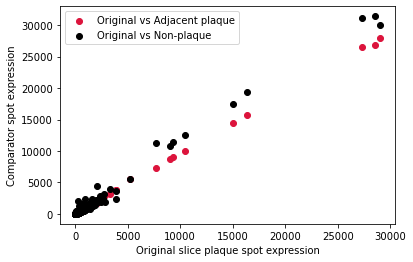

In [174]:
plt.scatter(np.mean(old_m, axis=0),np.mean(new_m, axis=0), c='crimson', label = 'Original vs Adjacent plaque')
plt.scatter(np.mean(old_m, axis=0),np.mean(no_m, axis=0), c='k', label = 'Original vs Non-plaque')
plt.xlabel('Original slice plaque spot expression')
plt.ylabel('Comparator spot expression')
plt.legend()
plt.show()

In [321]:
## Filter by non-overlapping spots
og_filt = og_gene_df.loc[(og_df['plaque'] == 1).values]
new_filt = gene_df.loc[(spot_df['plaque'] == 1).values]
no_filt = gene_df.loc[(spot_df['plaque'] == 0).values]
og_filt

,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Rb1cc1,St18,Pcmtd1,...,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,Spry3,Tmlhe,AC149090.1
AAAGACCCAAGTCGCG-1,0.0,66.577896,0.000000,199.733688,0.000000,0.000000,0.0,66.577896,0.0,66.577896,...,532.623169,8788.282227,1464.713745,133.155792,14580.559570,0.000000,66.577896,66.577896,0.0,266.311584
AACACGACTGTACTGA-1,0.0,74.537865,74.537865,0.000000,0.000000,0.000000,0.0,74.537865,0.0,0.000000,...,447.227173,17814.548828,2012.522339,74.537865,23703.041016,74.537865,0.000000,0.000000,0.0,149.075729
AACCGAGCTTGGTCAT-1,0.0,0.000000,0.000000,0.000000,0.000000,283.559235,0.0,170.135529,0.0,56.711845,...,283.559235,10378.267578,1587.931641,56.711845,16106.164062,0.000000,56.711845,56.711845,0.0,226.847382
AACCGTTGTGTTTGCT-1,0.0,0.000000,81.294205,0.000000,0.000000,162.588409,0.0,0.000000,0.0,0.000000,...,243.882614,7153.890137,975.530457,0.000000,12681.895508,0.000000,0.000000,0.000000,0.0,0.000000
AACTGATATTAGGCCT-1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,192.752502,0.0,64.250832,...,257.003326,13364.172852,1991.775757,0.000000,16319.710938,0.000000,64.250832,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTAATCAGTACGTCAG-1,0.0,63.799919,63.799919,63.799919,127.599838,127.599838,0.0,127.599838,0.0,0.000000,...,255.199677,10016.586914,1594.997925,191.399750,15120.581055,0.000000,63.799919,0.000000,0.0,382.799500
TTCATGGCGCAACAGG-1,0.0,104.047455,34.682484,69.364967,0.000000,208.094910,0.0,0.000000,0.0,173.412415,...,485.554779,14115.770508,1907.536621,34.682484,18208.304688,0.000000,0.000000,0.000000,0.0,277.459869
TTCGGTACTGTAGAGG-1,0.0,0.000000,0.000000,0.000000,0.000000,469.836487,0.0,0.000000,0.0,93.967300,...,375.869202,14283.029297,1597.444092,0.000000,16914.113281,0.000000,93.967300,0.000000,0.0,93.967300
TTGGGAAGACGAGCCG-1,0.0,242.522232,242.522232,161.681488,80.840744,161.681488,0.0,161.681488,0.0,80.840744,...,404.203735,18270.007812,2344.381592,161.681488,21665.320312,0.000000,0.000000,0.000000,0.0,242.522232


In [356]:
cort_l

('Cortex Layer 2/3', 'Cortex Layer 4', 'Cortex Layer 5/6a', 'Cortex Layer 6')

In [392]:
#filter plaques and cortex only
cort_i = []
for i in cort_l:
    cort_i = np.append(cort_i, np.where(spot_df['anot']==i))

og_plq = np.intersect1d(np.where(og_df['plaque']==1)[0], cort_i)
new_plq = np.intersect1d(np.where(spot_df['plaque']==1)[0], cort_i)
no_plq = np.intersect1d(np.where(spot_df['plaque']==0)[0], cort_i)

shared = np.intersect1d(og_plq, new_plq)
og_notin = np.setxor1d(og_plq, shared)
new_notin = np.setxor1d(new_plq, shared)


In [393]:
og_v = np.asarray(og_gene_df.iloc[og_notin])
new_v = np.asarray(gene_df.iloc[new_notin])
no_v = np.asarray(gene_df.iloc[no_plq])
no_v.shape, og_v.shape, new_v.shape

((945, 12404), (69, 12404), (71, 12404))

In [394]:
# perform PCA on og_v
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
og_sc = scaler.fit_transform(og_v)
new_sc = scaler.fit_transform(new_v)
no_sc = scaler.fit_transform(no_v)

pca = PCA(n_components=3)
pca.fit(no_sc)
og_pca = pca.transform(og_sc)
new_pca = pca.transform(new_sc)
no_pca = pca.transform(no_sc)

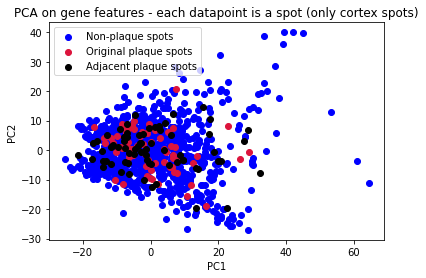

In [562]:
plt.title('PCA on gene features - each datapoint is a spot (only cortex spots)')
plt.scatter(no_pca[:,0], no_pca[:,1], c='b', label = 'Non-plaque spots')
plt.scatter(og_pca[:,0], og_pca[:,1], c='crimson', label = 'Original plaque spots')
plt.scatter(new_pca[:,0], new_pca[:,1], c='k', label = 'Adjacent plaque spots')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig(s_fig + 'plaque-pca.svg', transparent=True)
plt.show()

In [402]:
no_v.shape, og_v.shape, new_v.shape

((945, 12404), (69, 12404), (71, 12404))

In [400]:
# Calculate correlations across plaque spots
plaq_c = np.corrcoef(og_v, new_v)[:new_v.shape[0],new_v.shape[0]:]
plaq_ = np.ravel(plaq_c)
print(plaq_c.shape)

# Calculate correlations plaque - no plaque spots
noplaq_c = np.corrcoef(no_v, new_v)[:new_v.shape[0],new_v.shape[0]:]
noplaq_ = np.ravel(noplaq_c)
print(noplaq_c.shape)

(71, 69)
(71, 945)


In [403]:
np.mean(plaq_), np.mean(noplaq_)

(0.9472961594243551, 0.9411425100557002)

In [564]:
df=pd.DataFrame()
df['correlation'] = np.append(plaq_, noplaq_)
df['plaque'] = np.append(np.full(len(plaq_), 1), np.full(len(noplaq_), 0))
df

,correlation,plaque
0,0.951684,1
1,0.971555,1
2,0.961224,1
3,0.972828,1
4,0.874705,1
...,...,...
71989,0.967256,0
71990,0.959363,0
71991,0.932952,0
71992,0.971607,0


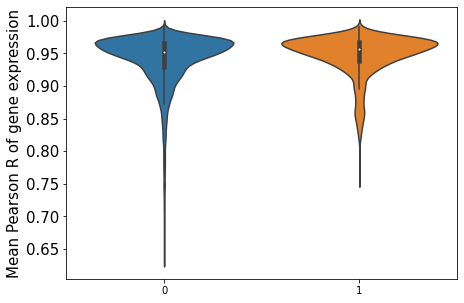

In [570]:
fig,ax = plt.subplots(figsize=(7,5))
sns.violinplot(data=df, x="plaque", y="correlation", jitter=0.2, alpha=0.5)
#
ax.set(xlabel=None)
#plt.xticks([0,1], ['Adjacent plaque - Non-plaque spots', 'Adjacent - Original plaque spots'], fontsize=15)
#plt.xticks(rotation=90)
plt.yticks(fontsize=15)
plt.ylabel('Mean Pearson R of gene expression', fontsize=15)
plt.savefig(s_fig + 'plaque-correlation.svg', transparent=True)
plt.show()

In [421]:
## COMPARE DE GENES
#filter plaques and cortex only
cort_i = []
for i in cort_l:
    cort_i = np.append(cort_i, np.where(spot_df['anot']==i))

og_plq = np.intersect1d(np.where(og_df['plaque']==1)[0], cort_i)
no_plq_og = np.intersect1d(np.where(og_df['plaque']==0)[0], cort_i)

new_plq = np.intersect1d(np.where(spot_df['plaque']==1)[0], cort_i)
no_plq_new = np.intersect1d(np.where(spot_df['plaque']==0)[0], cort_i)

plq_og_v = np.asarray(og_gene_df.iloc[og_plq])
no_og_v = np.asarray(og_gene_df.iloc[no_plq_og])

plq_new_v = np.asarray(gene_df.iloc[new_plq])
no_new_v = np.asarray(gene_df.iloc[no_plq_new])

plq_og_v.shape, no_og_v.shape, plq_new_v.shape, no_new_v.shape

((90, 12404), (947, 12404), (92, 12404), (945, 12404))

In [425]:
name_i = gene_df.columns.values
name_i.shape

(12404,)

In [594]:
# Find DE genes in original section
data1,data2=plq_og_v, no_og_v

import scipy
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(data1[:,i], data2[:,i], alternative='two-sided') for i in range(data1.shape[1])])
p_vals = np.vstack(mwu)[:,1]
# # sig_ = p_vals < 0.05/gene_m.shape[1]
sig_v, adj_p_vals = mne.stats.fdr_correction(p_vals, 0.05, 'indep') #Use Benjamini hochberg FDR test 
sig_genes = name_i[sig_v]


In [603]:
np.intersect1d(sig_genes, new_sig_genes)

array(['B2m', 'C1qa', 'C4b', 'Ctsd', 'Ctss', 'Gfap', 'H2-Aa', 'H2-D1',
       'Ifi27l2a', 'Lgals3bp', 'Ly6h', 'Ncdn', 'Serpina3n', 'Tyrobp'],
      dtype=object)

In [601]:
np.sort(sig_genes)

array(['Atp2b4', 'B2m', 'C1qa', 'C4b', 'Cabp7', 'Ccl12', 'Cox6a1', 'Ctsd',
       'Ctss', 'Flt3l', 'Fth1', 'Gfap', 'H2-Aa', 'H2-D1', 'H2-K1',
       'Hist1h1c', 'Ifi27l2a', 'Lair1', 'Lgals3bp', 'Ly6e', 'Ly6h',
       'Mapk1', 'Meg3', 'Mfge8', 'Mmp17', 'Ncdn', 'Nmnat2', 'Pcp4',
       'Prss23', 'Rapgef4', 'Serpina3n', 'Spred2', 'Thra', 'Trbc2',
       'Tspan7', 'Tyrobp'], dtype=object)

In [602]:
np.sort(new_sig_genes)

array(['Anxa3', 'Asb2', 'B2m', 'Bst2', 'C1qa', 'C1qb', 'C1qc', 'C4b',
       'Ccl5', 'Cd44', 'Cd52', 'Cd68', 'Cd74', 'Cd84', 'Cela1', 'Chl1',
       'Cmtm6', 'Coa5', 'Csf3r', 'Cst7', 'Ctsb', 'Ctsd', 'Ctsl', 'Ctss',
       'Cxcl16', 'Dhrs1', 'Efna5', 'Fcer1g', 'Fcrls', 'Ftl1', 'Fxyd1',
       'Gfap', 'Gpcpd1', 'Gpr34', 'H2-Aa', 'H2-Ab1', 'H2-D1', 'Hexb',
       'Ifi27', 'Ifi27l2a', 'Ifit3', 'Ifitm3', 'Irgm1', 'Isg15', 'Klk6',
       'Lgals3bp', 'Ly6h', 'Ly86', 'Lyz2', 'Mpeg1', 'Ncdn', 'Ncf2',
       'Nek6', 'Olfml3', 'Pole3', 'Ppip5k2', 'Ptpn6', 'Pycard', 'S100a6',
       'Serpina3n', 'Sparc', 'Tagln2', 'Tnfaip8l2', 'Trem2', 'Tyrobp',
       'Vim', 'Zfp809'], dtype=object)

In [596]:
#Volcano plot
lgf2 = np.asarray([np.log2(np.mean(data1[:,i])/np.mean(data2[:,i])) for i in range(data1.shape[1])])
value1 = np.asarray([np.mean(data1[:,i]) for i in range(data1.shape[1])])
value2 = np.asarray([np.mean(data2[:,i]) for i in range(data2.shape[1])])
df = {'GeneNames': np.array(name_i), 'plaque': value1, 'no plaque':value2, 'log2FC': lgf2, 'p-value': adj_p_vals}
df = pd.DataFrame(df)

#Find top n DE genes
sorted = np.sort(adj_p_vals)[:10]
top_n = [df['GeneNames'].iloc[np.where(adj_p_vals == i)[0][0]] for i in sorted]
df


<ipython-input-596-cf7c8e993681>:2: RuntimeWarning: divide by zero encountered in log2
  lgf2 = np.asarray([np.log2(np.mean(data1[:,i])/np.mean(data2[:,i])) for i in range(data1.shape[1])])


,GeneNames,plaque,no plaque,log2FC,p-value
0,Sox17,9.626844,4.985401,0.949354,0.621706
1,Mrpl15,40.853493,51.272083,-0.327714,0.756761
2,Lypla1,34.528564,39.779110,-0.204221,0.766850
3,Tcea1,74.593124,74.728897,-0.002624,0.903044
4,Rgs20,36.618835,34.037273,0.105470,0.942611
...,...,...,...,...,...
12399,CAAA01118383.1,8.049618,8.058754,-0.001636,0.906167
12400,Vamp7,43.984745,37.730717,0.221264,0.808954
12401,Spry3,6.129004,7.231562,-0.238655,0.919539
12402,Tmlhe,4.115935,3.195363,0.365240,0.863636


In [538]:
top_n

['H2-D1',
 'B2m',
 'Gfap',
 'Lgals3bp',
 'Ly6e',
 'Ifi27l2a',
 'Ifi27l2a',
 'Ctss',
 'Pcp4',
 'Cox6a1']

In [597]:
#from bioinfokit import analys, visuz
# load dataset as pandas dataframe
visuz.GeneExpression.volcano(df=df, dim = (10,8), color = ('red', 'grey', 'green') , lfc='log2FC', pv='p-value', 
                            gstyle=1, geneid = 'GeneNames', lfc_thr=(0.5,0.5), valpha = 0.8, 
                            genenames = tuple(top_n), sign_line=True
                             ,plotlegend=True, legendpos='upper left',
                             axtickfontsize = 25, axtickfontname='sans',axlabelfontsize=25, dotsize = 25, gfont=15, figtype='png')
    
                            

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/colors.py:1310: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/ticker.py:536: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [598]:
# Find DE genes in original section
data1,data2=plq_new_v, no_new_v

import scipy
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(data1[:,i], data2[:,i], alternative='two-sided') for i in range(data1.shape[1])])
p_vals = np.vstack(mwu)[:,1]
# # sig_ = p_vals < 0.05/gene_m.shape[1]
sig_v, adj_p_vals = mne.stats.fdr_correction(p_vals, 0.05, 'indep') #Use Benjamini hochberg FDR test 
new_sig_genes = name_i[sig_v]


In [591]:
#Volcano plot
lgf2 = np.asarray([np.log2(np.mean(data1[:,i])/np.mean(data2[:,i])) for i in range(data1.shape[1])])
value1 = np.asarray([np.mean(data1[:,i]) for i in range(data1.shape[1])])
value2 = np.asarray([np.mean(data2[:,i]) for i in range(data2.shape[1])])
df = {'GeneNames': np.array(name_i), 'plaque': value1, 'no plaque':value2, 'log2FC': lgf2, 'p-value': adj_p_vals}
df = pd.DataFrame(df)

#Find top n DE genes
sorted = np.sort(adj_p_vals)[:10]
top_n = [df['GeneNames'].iloc[np.where(adj_p_vals == i)[0][0]] for i in sorted]
df


<ipython-input-591-cf7c8e993681>:2: RuntimeWarning: divide by zero encountered in log2
  lgf2 = np.asarray([np.log2(np.mean(data1[:,i])/np.mean(data2[:,i])) for i in range(data1.shape[1])])


,GeneNames,plaque,no plaque,log2FC,p-value
0,Sox17,4.711431,5.454115,-0.211180,0.983591
1,Mrpl15,51.871559,50.221474,0.046639,0.995621
2,Lypla1,46.373020,38.637112,0.263298,0.907690
3,Tcea1,62.580536,75.898659,-0.278360,0.700067
4,Rgs20,38.617672,33.837215,0.190650,0.948626
...,...,...,...,...,...
12399,CAAA01118383.1,6.352973,8.223949,-0.372400,0.919022
12400,Vamp7,37.901993,38.309662,-0.015435,0.985376
12401,Spry3,5.804730,7.265466,-0.323826,0.904473
12402,Tmlhe,2.097820,3.389888,-0.692347,0.912611


In [593]:
#from bioinfokit import analys, visuz
# load dataset as pandas dataframe
visuz.GeneExpression.volcano(df=df, dim = (10,8), color = ('red', 'grey', 'green') , lfc='log2FC', pv='p-value', 
                            gstyle=1, geneid = 'GeneNames', lfc_thr=(0.5,0.5), valpha = 0.8, 
                            genenames = tuple(top_n), sign_line=True
                             ,plotlegend=True, legendpos='upper left',
                             axtickfontsize = 25, axtickfontname='sans',axlabelfontsize=25, dotsize = 25, gfont=15, figtype='png')
    
                            

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/colors.py:1310: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/ticker.py:536: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [547]:
np.sort(np.intersect1d(new_sig_genes, sig_genes))

array(['B2m', 'C1qa', 'C4b', 'Ctsd', 'Ctss', 'Gfap', 'H2-Aa', 'H2-D1',
       'Ifi27l2a', 'Lgals3bp', 'Ly6h', 'Ncdn', 'Serpina3n', 'Tyrobp'],
      dtype=object)

# Correlate APP expression with plaque levels

In [15]:
np.append(gene_all, gene_df['humanAPP'].values)

array([594.2948 , 953.113  , 198.62947, ..., 135.54422, 216.73952,
       229.06883], dtype=float32)

In [16]:
#group data together
name_l = '030-B', '030-C', '040-A', '040-C', '040-D'

for name in name_l:
    spot_df, gene_df = run_(name)
    if name == name_l[0]: 
        gene_all = gene_df['humanAPP'].values
        lab = spot_df['plaque']
        name_all = np.repeat(name, len(gene_df['humanAPP'].values))
    else: 
        gene_all = np.append(gene_all, gene_df['humanAPP'].values)
        lab = np.hstack((lab, spot_df['plaque']))
        name_all = np.hstack((name_all, np.repeat(name, len(gene_df['humanAPP'].values))))

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2939
Number of genes: 32285


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3532
Number of genes: 32285


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3465
Number of genes: 32285


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3616
Number of genes: 32285


/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3457
Number of genes: 32285


In [68]:
df = pd.DataFrame({'human APP CPMs': gene_all, 'plaque': lab, 'sample': name_all})
df

,human APP CPMs,plaque,sample
0,594.294800,0,030-B
1,953.112976,0,030-B
2,198.629471,0,030-B
3,285.861298,0,030-B
4,195.121948,0,030-B
...,...,...,...
17004,366.193054,0,040-D
17005,429.397186,0,040-D
17006,365.020599,0,040-D
17007,730.239502,0,040-D


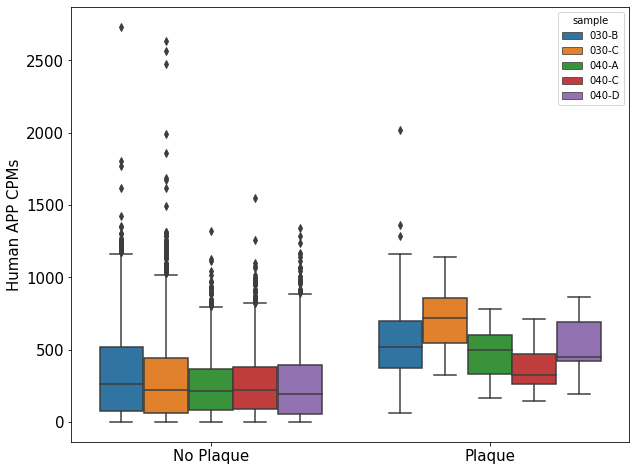

In [78]:
import seaborn as sns
# Correlate human APP expression with plaque load -- treat each spot independently
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x = 'plaque', y ='human APP CPMs', hue = 'sample')
#set label names and size
ax.set_ylabel('Human APP CPMs', fontsize=15)
#remove x label
ax.set_xlabel('')
#change x tick names
ax.set_xticklabels(['No Plaque', 'Plaque'], fontsize=15)
#increase y tick size
ax.tick_params(axis='y', labelsize=15)
plt.show()

In [86]:
i=0
df['human APP CPMs'].iloc[np.where((df['plaque'] == 0) & (df['sample'] == name_l[i]))[0]].values

array([594.2948 , 953.113  , 198.62947, ..., 937.20715, 201.57227,
         0.     ], dtype=float32)

In [89]:
# significant test
from scipy.stats import mannwhitneyu
# Wilcoxon signed rank test
for i in range(len(name_l)):
    print(mannwhitneyu(df['human APP CPMs'].iloc[np.where((df['plaque'] == 0) & (df['sample'] == name_l[i]))[0]].values, df['human APP CPMs'].iloc[np.where((df['plaque'] == 1) & (df['sample'] == name_l[i]))[0]].values, alternative='two-sided'))

MannwhitneyuResult(statistic=77535.0, pvalue=1.1736246740466518e-15)
MannwhitneyuResult(statistic=4786.0, pvalue=1.4367573145619633e-05)
MannwhitneyuResult(statistic=8506.0, pvalue=0.0004035117312429103)
MannwhitneyuResult(statistic=41053.0, pvalue=6.613302926617175e-05)
MannwhitneyuResult(statistic=9409.0, pvalue=4.89089698665726e-06)


In [105]:
from scipy.stats import pointbiserialr

pointbiserialr(df['plaque'], df['human APP CPMs'])

SignificanceResult(statistic=0.1044420687279617, pvalue=1.8201273802524843e-42)

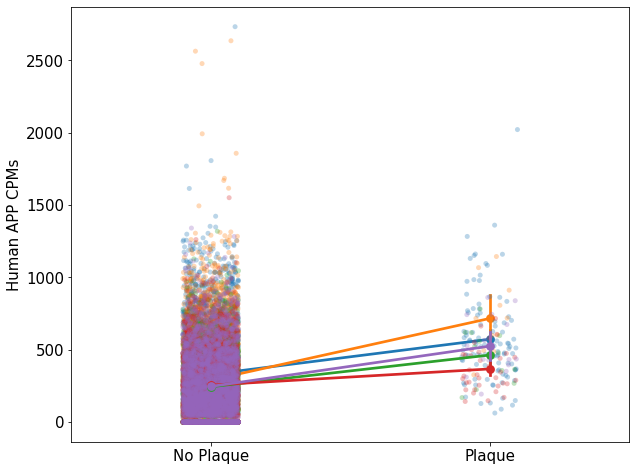

In [102]:
import seaborn as sns
# Correlate human APP expression with plaque load -- treat each spot independently
fig,ax = plt.subplots(figsize=(10,8))
sns.stripplot(data=df, x = 'plaque', y ='human APP CPMs', hue = 'sample', alpha=0.3)
sns.pointplot(data=df, x = 'plaque', y ='human APP CPMs', hue = 'sample', label=None)#, ci=None, color='grey')

#set label names and size
ax.set_ylabel('Human APP CPMs', fontsize=15)
#remove x label
ax.set_xlabel('')
#change x tick names
ax.set_xticklabels(['No Plaque', 'Plaque'], fontsize=15)
#increase y tick size
ax.tick_params(axis='y', labelsize=15)
#remove legend
ax.legend_.remove()
plt.show()

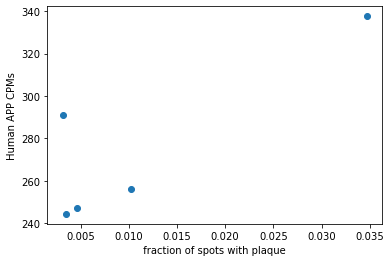

In [52]:
plt.scatter(plq_pc, curr_exp)
#set x and y axis labels
plt.xlabel(' fraction of spots with plaque ')
plt.ylabel('Human APP CPMs')
plt.show()

In [40]:
curr_exp, sum_plq

(247.18889, 16)

In [ ]:
# Correlate human APP expression with plaque load -- mean for each sample


# Plaque differential expression


In [19]:
#sort out names
import glob
import os
os.chdir('/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/')
og = glob.glob('*.json')
ID = [i.split('.')[0] for i in og]
sub_ID=[]
for x,i in enumerate(og):
    if x != 5: sub_ID = np.append(sub_ID, i.split('_')[1][:-5])
    else: sub_ID = np.append(sub_ID, i[:-5])\
ID, sub_ID


(['V11Y17_109-D',
  'V11Y10_030-C',
  'S29_030-D',
  'V11Y17_109-A',
  'V10S15_040-C',
  '030-B',
  'V11Y17_109-C',
  'V10S15_040-A',
  'V10S15_040-D'],
 array(['109-D', '030-C', '030-D', '109-A', '040-C', '030-B', '109-C',
        '040-A', '040-D'], dtype='<U32'))

In [52]:
#Load in metadata
meta = pd.read_csv('/cndd2/agelber/hal/metadata.csv')
meta

,sample,age,sex,genotype,time,sample_number,sample_name,resequenced
0,039-A_S18,7 months,F,WT,ZT0,S18,039-A,False
1,039-B_S19,7 months,F,WT,ZT6,S19,039-B,True
2,039-C_S20,7 months,F,WT,ZT12,S20,039-C,True
3,039-D_S21,7 months,F,WT,ZT18,S21,039-D,False
4,042-A_S22,7 months,M,WT,ZT6,S22,042-A,False
...,...,...,...,...,...,...,...,...
61,351-D_S12,14 months,F,WT,ZT18,S12,351-D,False
62,043-A_S12,14 months,F,APP23,ZT0,S12,043-A,True
63,043-B_S13,14 months,M,APP23,ZT6,S13,043-B,True
64,043-C_S14,14 months,F,WT,ZT12,S14,043-C,True


In [ ]:
#Pull out sex and time for each sample
sex_l = [meta['sex'][meta['sample_name'] == i].values[0] for i in sub_ID]
time_l = [meta['timepoint'][meta['sample_name'] == i].values[0] for i in sub_ID]

In [ ]:
df["Period"] = df['Courses'].astype(str) +"-"+ df["Duration"]
print(df)

In [95]:
spot_df

,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,plaque,cluster,anot
175133,AAACAAGTATCTCCCA-1,1,50,102,403,1523,0,10,Cortex Layer 4
175134,AAACACCAATAACTGC-1,1,59,19,1301,1696,0,12,Fiber Tracts 2
175135,AAACAGAGCGACTCCT-1,1,14,94,492,846,0,5,Fiber Tracts 1
175136,AAACAGCTTTCAGAAG-1,1,43,9,1410,1395,0,17,Piriform Cortex
175137,AAACAGGGTCTATATT-1,1,47,13,1366,1470,0,17,Piriform Cortex
...,...,...,...,...,...,...,...,...,...
178630,TTGTTGTGTGTCAAGA-1,1,31,77,675,1167,0,8,CA3
178631,TTGTTTCACATCCAGG-1,1,58,42,1052,1676,0,12,Fiber Tracts 2
178632,TTGTTTCATTAGTCTA-1,1,60,30,1181,1715,0,17,Piriform Cortex
178633,TTGTTTCCATACAACT-1,1,45,27,1215,1432,0,17,Piriform Cortex


In [96]:
#group data together for DESEQ
# Plaque vs no plaque
name_l = ID
drop = [] #genes with < 10 counts in a single sample to drop

#Pull out sex and time for each sample
sex_l = [meta['sex'][meta['sample_name'] == i].values[0] for i in sub_ID]

for x,name in enumerate(name_l):
    spot_df, gene_df = run_(name, sub_ID[x])
    sample = np.full(len(spot_df), sub_ID[x])
    sex = np.full(len(spot_df), sex_l[x])
    spot_df['sample'] = sample
    spot_df['sex'] = sex

    new_df = spot_df[['barcode', 'sample', 'sex', 'plaque', 'anot']]
    new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
    drop = np.append(drop, gene_df.T[np.sum(gene_df, axis=0) < 10].index.values)
    if name == name_l[0]: 
        gene_all = gene_df
        lab = new_df
    else: 
        gene_all = pd.concat([gene_all, gene_df], axis=0)
        lab = pd.concat([lab, new_df], axis=0)

gene_all = gene_all.T #genes x rows needed for DESEQ
gene_all.drop(np.unique(drop), axis=0, inplace=True)
lab = lab.set_index('barcode')

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3502
Number of genes: 32284


<ipython-input-96-759f925f92d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3532
Number of genes: 32284


<ipython-input-96-759f925f92d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3382
Number of genes: 32284


<ipython-input-96-759f925f92d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3459
Number of genes: 32284


<ipython-input-96-759f925f92d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3616
Number of genes: 32284


<ipython-input-96-759f925f92d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 2939
Number of genes: 32284


<ipython-input-96-759f925f92d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3410
Number of genes: 32284


<ipython-input-96-759f925f92d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3465
Number of genes: 32284


<ipython-input-96-759f925f92d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Number of spots: 3457
Number of genes: 32284


<ipython-input-96-759f925f92d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['barcode'] = new_df['barcode'].astype(str)+'_'+new_df['sample'].astype(str)


In [98]:
gene_all

,AAACAAGTATCTCCCA-1,AAACACCAATAACTGC-1,AAACAGAGCGACTCCT-1,AAACAGCTTTCAGAAG-1,AAACAGGGTCTATATT-1,AAACATTTCCCGGATT-1,AAACCCGAACGAAATC-1,AAACCGGGTAGGTACC-1,AAACCGTTCGTCCAGG-1,AAACCTAAGCAGCCGG-1,...,TTGTGTTTCCCGAAAG-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGGCAATGACTG-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTCCATACAACT-1,TTGTTTGTATTACACG-1,TTGTTTGTGTAAATTC-1
Xkr4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm19938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sox17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mrpl15,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
Lypla1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vamp7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,1.0,2.0,3.0,2.0,0.0
Spry3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tmlhe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAAA01147332.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
lab

,sample,sex,plaque,anot
barcode,,,,
AAACAAGTATCTCCCA-1_109-D,109-D,M,0,Cortex Layer 4
AAACACCAATAACTGC-1_109-D,109-D,M,0,Fiber Tracts 2
AAACAGAGCGACTCCT-1_109-D,109-D,M,0,Fiber Tracts 1
AAACAGCTTTCAGAAG-1_109-D,109-D,M,0,Piriform Cortex
AAACAGGGTCTATATT-1_109-D,109-D,M,0,Piriform Cortex
...,...,...,...,...
TTGTTTCACATCCAGG-1_040-D,040-D,F,0,Cortex Layer 6
TTGTTTCATTAGTCTA-1_040-D,040-D,F,0,Cortex Layer 5/6a
TTGTTTCCATACAACT-1_040-D,040-D,F,0,Cortex Layer 2/3


In [ ]:
#Subset by brain area

In [41]:
gene_all.shape

(14241, 30762)

In [43]:
#write to hdf
gene_all.to_hdf(r'/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/DESEQ/old-app-plaque_counts.h5', key='count_mat')
lab.to_hdf(r'/cndd3/dburrows/DATA/spatial_transcriptomics/plaques/DESEQ/old-app-plaque_meta.h5', key='metadata', mode='w')

ValueError: Columns index has to be unique for fixed format

In [17]:
#Sample level QC



In [7]:
gene_all

,AAACAAGTATCTCCCA-1,AAACACCAATAACTGC-1,AAACAGAGCGACTCCT-1,AAACAGCTTTCAGAAG-1,AAACAGGGTCTATATT-1,AAACATTTCCCGGATT-1,AAACCCGAACGAAATC-1,AAACCGGGTAGGTACC-1,AAACCGTTCGTCCAGG-1,AAACCTAAGCAGCCGG-1,...,TTGTGTTTCCCGAAAG-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGGCAATGACTG-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTCCATACAACT-1,TTGTTTGTATTACACG-1,TTGTTTGTGTAAATTC-1
Xkr4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm19938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sox17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mrpl15,0.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
Lypla1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vamp7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,1.0,2.0,3.0,2.0,0.0
Spry3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tmlhe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAAA01147332.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
lab

,sample,plaque,anot
barcode,,,
AAACAAGTATCTCCCA-1,109-D,0,Cortex Layer 4
AAACACCAATAACTGC-1,109-D,0,Fiber Tracts 2
AAACAGAGCGACTCCT-1,109-D,0,Fiber Tracts 1
AAACAGCTTTCAGAAG-1,109-D,0,Piriform Cortex
AAACAGGGTCTATATT-1,109-D,0,Piriform Cortex
...,...,...,...
TTGTTTCACATCCAGG-1,040-D,0,Cortex Layer 6
TTGTTTCATTAGTCTA-1,040-D,0,Cortex Layer 5/6a
TTGTTTCCATACAACT-1,040-D,0,Cortex Layer 2/3


In [ ]:
#Make plaque-adjacet dataframe for DESEQ
# PA vs plaque
# PA vs no plaque

spot_df, gene_df = run_(ID[0], sub_ID[0])
#PLOT PLAQUES
fig = plt.figure(figsize=(8,8))
xcoord, ycoord = spot_df['array_row'].values, spot_df['array_col'].values
plq_bool = spot_df['plaque'].values == 1

plt.scatter(xcoord, ycoord, s=1, c='k')
plt.scatter(xcoord[plq_bool], ycoord[plq_bool], s=5, c='red')
plt.show()


In [ ]:
# Split by brain region


In [ ]:
#

In [20]:
gene_all.T[lab['sample']==u].sum(axis=1) 

AAACAAGTATCTCCCA-1    10942.0
AAACACCAATAACTGC-1     2611.0
AAACAGAGCGACTCCT-1     2554.0
AAACAGCTTTCAGAAG-1     8981.0
AAACAGGGTCTATATT-1     6704.0
                       ...   
TTGTTGTGTGTCAAGA-1     8669.0
TTGTTTCACATCCAGG-1     2898.0
TTGTTTCATTAGTCTA-1     3951.0
TTGTTTCCATACAACT-1     6920.0
TTGTTTGTGTAAATTC-1     7088.0
Length: 3502, dtype: float32

In [ ]:
# Microenvironment plaque label

In [94]:
gene_all.T[(lab['sample'] == u).values].sum(axis=0) < 10

Xkr4          False
Gm1992         True
Gm19938       False
Gm37381        True
Rp1            True
              ...  
AC124606.1     True
AC133095.2     True
AC133095.1     True
AC234645.1     True
AC149090.1    False
Length: 32284, dtype: bool

## Whole slice


In [15]:
gene_m.shape, rows.shape

((3552, 16805), (3552,))

In [542]:
# Find DE genes

umi_plq = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool]
umi_norm = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool==False]

geneplq_m = np.vstack([gene_m[np.asarray(umi_plq)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_plq)))])
genenorm_m = np.vstack([gene_m[np.asarray(umi_norm)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_norm)))])
geneplq_m.shape, umi_plq.shape, genenorm_m.shape, umi_norm.shape

import scipy
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(geneplq_m[:,i], genenorm_m[:,i]) for i in range(gene_m.shape[1])])
p_vals = np.vstack(mwu)[:,1]
# sig_ = p_vals < 0.05/gene_m.shape[1]
sig_v, adj_p_vals = mne.stats.fdr_correction(p_vals, 0.05, 'indep') #Use Benjamini hochberg FDR test 
sig_genes = gene_.var.index[sig_v]


In [543]:
#Volcano plot
lgf2 = np.asarray([np.log2(np.mean(geneplq_m[:,i]) - np.mean(genenorm_m[:,i])) for i in range(gene_m.shape[1])])
lgf2[np.isnan(lgf2)] = 0
value1 = np.asarray([np.mean(genenorm_m[:,i]) for i in range(gene_m.shape[1])])
value2 = np.asarray([np.mean(geneplq_m[:,i]) for i in range(gene_m.shape[1])])
df = {'GeneNames': np.array(gene_.var.index), 'value1': value1, 'value2':value2, 'log2FC': lgf2, 'p-value': adj_p_vals}
df = pd.DataFrame(df)

#Find top n DE genes
sorted = np.sort(adj_p_vals)[:10]
top_n = [df['GeneNames'].iloc[np.where(adj_p_vals == i)[0][0]] for i in sorted]

df


<ipython-input-543-7670b90127a2>:2: RuntimeWarning: invalid value encountered in log2
  lgf2 = np.asarray([np.log2(np.mean(geneplq_m[:,i]) - np.mean(genenorm_m[:,i])) for i in range(gene_m.shape[1])])


,GeneNames,value1,value2,log2FC,p-value
0,Xkr4,1.594261,1.034647,0.000000,9.445994e-01
1,Gm19938,0.971128,2.124656,0.206052,2.717138e-02
2,Sox17,5.309881,7.096316,0.837084,5.003480e-02
3,Mrpl15,41.813095,53.725334,3.574373,1.055117e-02
4,Lypla1,29.717205,40.485680,3.428742,2.820086e-03
...,...,...,...,...,...
16800,Spry3,9.515156,15.462439,2.572231,2.113764e-03
16801,Tmlhe,2.927776,5.302159,1.247553,9.931781e-04
16802,CAAA01147332.1,0.511697,0.863103,-1.508787,3.150635e-01
16803,AC149090.1,210.750290,203.011078,0.000000,2.866477e-01


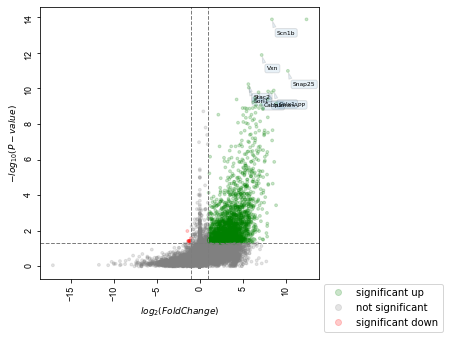

In [544]:
from bioinfokit import analys, visuz
# load dataset as pandas dataframe

visuz.GeneExpression.volcano(df=df, lfc='log2FC', pv='p-value', geneid = 'GeneNames', valpha = 0.2, genenames = tuple(top_n),gstyle=2, sign_line=True
                             ,plotlegend=True, legendpos='upper right',legendanchor=(1.46,0), show=True)
                            

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/colors.py:1310: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/ticker.py:536: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)


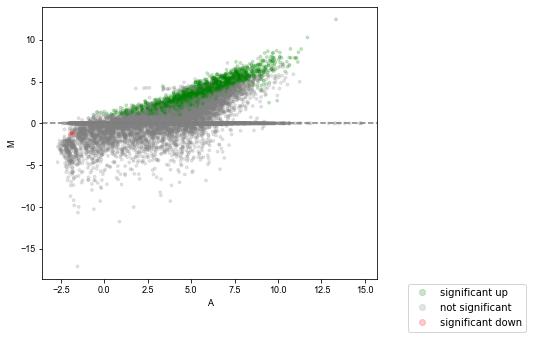

In [521]:
visuz.GeneExpression.ma(df=df, lfc='log2FC', ct_count='value1', st_count = 'value2',pv='p-value', valpha = 0.2, plotlegend=True, legendpos='upper right',legendanchor=(1.46,0),show=True)


In [373]:
# Visualise different DE gene expression in space
curr = 'Cd63'
if curr not in sig_genes:
    print('not a DE gene')
else:
    gene_ind = np.where(gene_.var.index== curr)[0][0]

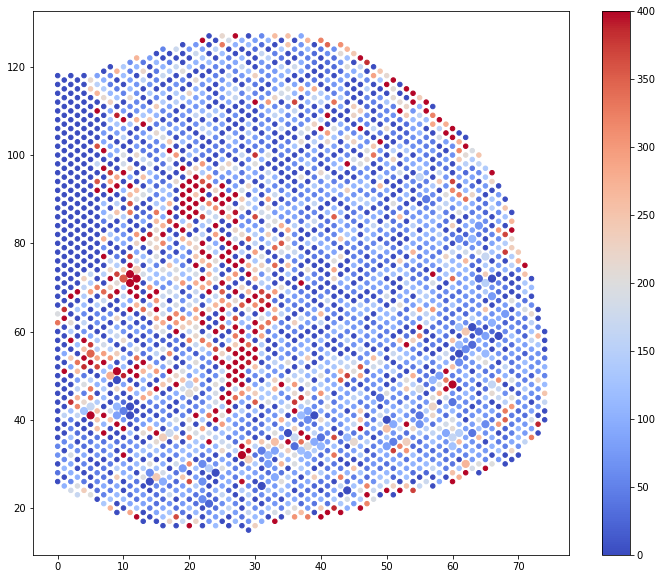

In [374]:

fig = plt.figure(figsize=(12,10))
plt.scatter(rows[plq_bool ==False], cols[plq_bool == False], s=20,c=genenorm_m[:,gene_ind], cmap='coolwarm', vmin = 0, vmax = 400)
plt.scatter(rows[plq_bool ==True], cols[plq_bool == True], s=50, c=geneplq_m[:,gene_ind], cmap='coolwarm', vmin = 0, vmax = 400)
plt.colorbar()
#plt.legend()
plt.savefig('fig_dump/plaque-cd63.png', transparent=True)
plt.show()

## Clusters


In [238]:
# Group by cluster region
def match(curr_umi, umi_plq, umi_norm):
    curr_plq = np.intersect1d(umi_plq,curr_umi)
    curr_norm = np.intersect1d(umi_norm,curr_umi)
    return(curr_norm, curr_plq)

umi_plq = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool]
umi_norm = coord_df['barcode'][coord_df['in_tissue']==1][plq_bool==False]
umi_split_l = [match(clust_l[i], umi_plq, umi_norm) for i in range(len(clust_l))]

In [132]:
#Select cluster 
#Only do DE on clusters with > 5 spots with plaques
for i in range(len(umi_split_l)):
    print('clust ' + str(i) + ' n-plaques=' + str(len(umi_split_l[i][1])))
        


clust 0 n-plaques=4
clust 1 n-plaques=0
clust 2 n-plaques=4
clust 3 n-plaques=16
clust 4 n-plaques=1
clust 5 n-plaques=3
clust 6 n-plaques=46
clust 7 n-plaques=0
clust 8 n-plaques=8
clust 9 n-plaques=13
clust 10 n-plaques=1
clust 11 n-plaques=1
clust 12 n-plaques=6
clust 13 n-plaques=1
clust 14 n-plaques=0


In [350]:
# choose cluster
ch = 6
umi_norm = umi_split_l[ch][0]
umi_plq = umi_split_l[ch][1]
geneplq_m = np.vstack([gene_m[np.asarray(umi_plq)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_plq)))])
genenorm_m = np.vstack([gene_m[np.asarray(umi_norm)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_norm)))])
geneplq_m.shape, genenorm_m.shape

((46, 16805), (246, 16805))

In [351]:
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(geneplq_m[:,i], genenorm_m[:,i]) for i in range(gene_m.shape[1])])
p_vals = np.vstack(mwu)[:,1]
# sig_ = p_vals < 0.05/gene_m.shape[1]
sig_v, adj_p_vals = mne.stats.fdr_correction(p_vals, 0.05, 'indep') #Use Benjamini hochberg FDR test 
sig_genes = gene_.var.index[sig_v]


In [352]:
np.sort(sig_genes)


array(['Gm19522'], dtype=object)

In [545]:
# Group by cortical regions (3,6,8,9)
cort_l = [3,6,8,9]
ch = 3
umi_norm = np.hstack(([umi_split_l[i][0] for i in cort_l]))
umi_plq = np.hstack(([umi_split_l[i][1] for i in cort_l]))
geneplq_m = np.vstack([gene_m[np.asarray(umi_plq)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_plq)))])
genenorm_m = np.vstack([gene_m[np.asarray(umi_norm)[i] == gene_.obs.index] for i in range(len(np.asarray(umi_norm)))])
geneplq_m.shape, genenorm_m.shape

((83, 16805), (1068, 16805))

In [546]:
import scipy
# Wilcoxon signed rank test
mwu = ([scipy.stats.mannwhitneyu(geneplq_m[:,i], genenorm_m[:,i]) for i in range(gene_m.shape[1])])
p_vals = np.vstack(mwu)[:,1]
# sig_ = p_vals < 0.05/gene_m.shape[1]
sig_v, adj_p_vals = mne.stats.fdr_correction(p_vals, 0.05, 'indep') #Use Benjamini hochberg FDR test 
sig_genes = gene_.var.index[sig_v]


In [547]:
#Volcano plot
lgf2 = np.asarray([np.log2(np.mean(geneplq_m[:,i]) - np.mean(genenorm_m[:,i])) for i in range(gene_m.shape[1])])
lgf2[np.isnan(lgf2)] = 0
value1 = np.asarray([np.mean(genenorm_m[:,i]) for i in range(gene_m.shape[1])])
value2 = np.asarray([np.mean(geneplq_m[:,i]) for i in range(gene_m.shape[1])])
df = {'GeneNames': np.array(gene_.var.index), 'value1': value1, 'value2':value2, 'log2FC': lgf2, 'adjusted p-value': adj_p_vals}
df = pd.DataFrame(df)

#Find top n DE genes
sorted = np.sort(adj_p_vals)[:10]
top_n = [df['GeneNames'].iloc[np.where(adj_p_vals == i)[0][0]] for i in sorted]

df


<ipython-input-547-e8d7026e9826>:2: RuntimeWarning: invalid value encountered in log2
  lgf2 = np.asarray([np.log2(np.mean(geneplq_m[:,i]) - np.mean(genenorm_m[:,i])) for i in range(gene_m.shape[1])])
<ipython-input-547-e8d7026e9826>:2: RuntimeWarning: divide by zero encountered in log2
  lgf2 = np.asarray([np.log2(np.mean(geneplq_m[:,i]) - np.mean(genenorm_m[:,i])) for i in range(gene_m.shape[1])])


,GeneNames,value1,value2,log2FC,adjusted p-value
0,Xkr4,1.546096,1.296426,0.000000,0.969011
1,Gm19938,1.306514,2.662219,0.439044,0.630130
2,Sox17,5.139546,5.154336,-6.079228,0.915314
3,Mrpl15,46.013012,60.985088,3.904202,0.125666
4,Lypla1,35.458939,45.381691,3.310740,0.435866
...,...,...,...,...,...
16800,Spry3,10.930652,14.435506,1.809354,0.633908
16801,Tmlhe,2.603630,6.070763,1.793743,0.169329
16802,CAAA01147332.1,0.781406,1.081479,-1.736617,0.915314
16803,AC149090.1,245.203796,226.067413,0.000000,0.795985


<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/colors.py:1310: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/ticker.py:536: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)


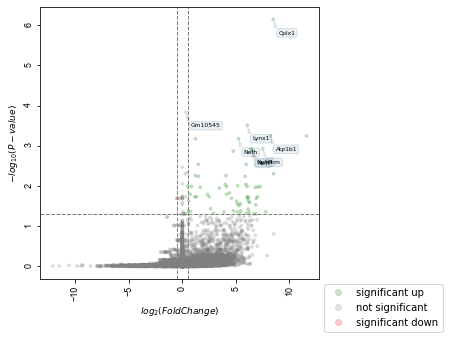

In [552]:
from bioinfokit import analys, visuz
# load dataset as pandas dataframe

visuz.GeneExpression.volcano(df=df, lfc='log2FC', pv='adjusted p-value', geneid = 'GeneNames', lfc_thr=(0.5,0.5), valpha = 0.2, genenames = tuple(top_n),gstyle=2, sign_line=True
                             ,plotlegend=True, legendpos='upper right',legendanchor=(1.46,0), show=True)
                            

/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/colors.py:1310: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/dburrows/anaconda3/envs/py_3916/lib/python3.9/site-packages/matplotlib/ticker.py:536: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)


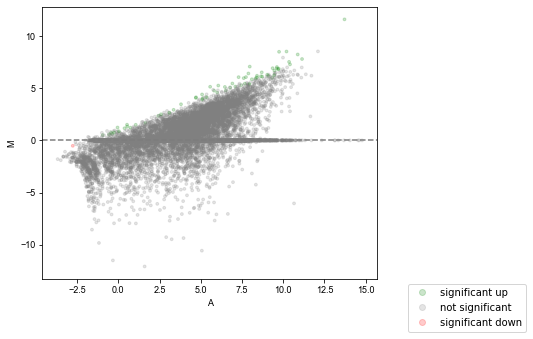

In [555]:
visuz.GeneExpression.ma(df=df, lfc='log2FC', ct_count='value1', st_count = 'value2',pv='adjusted p-value', lfc_thr=(0.5,0.5), valpha = 0.2, plotlegend=True, legendpos='upper right',legendanchor=(1.46,0),show=True)


In [270]:
np.sort(sig_genes)

array(['Abcd2', 'Accsl', 'Acot7', 'Ankrd66', 'Atp1a3', 'Atp1b1', 'Atp5b',
       'Atp5g3', 'Atp6ap2', 'Bcat1', 'Bcl6', 'Camk2a', 'Catip', 'Cd1d1',
       'Ckb', 'Col4a4', 'Colec11', 'Cox5a', 'Cplx1', 'Crip2', 'Ddn',
       'Dynll2', 'Epop', 'Epx', 'Ermard', 'Fanci', 'Fezf2', 'Gas2l3',
       'Gas5', 'Gbx1', 'Glrb', 'Gm10545', 'Gm17396', 'Gm20751', 'Gm2762',
       'Gm29737', 'Gm47814', 'Haghl', 'Hapln4', 'Hcn2', 'Hpcal4',
       'Ifi207', 'Ifitm6', 'Ina', 'Kcna2', 'Kctd9', 'Ldhb', 'Lipc',
       'Lynx1', 'Map1b', 'Marcks', 'Nat8l', 'Ndufc2', 'Nefh', 'Nefl',
       'Nefm', 'Nell1', 'Nrip3', 'Olfm1', 'Pcp4', 'Pde6c', 'Pde6g',
       'Peg13', 'Pkm', 'Pphln1', 'Psph', 'Pvalb', 'Pygm', 'Qrfpr',
       'Rasgef1a', 'Ripply3', 'Scn1b', 'Scn4b', 'Slpi', 'Smad3', 'Sorl1',
       'Stmn3', 'Sub1', 'Syt2', 'Tecr', 'Teddm3', 'Thy1', 'Tmem74bos',
       'Tshz2', 'Tubb3', 'Vamp1', 'Zdhhc15', 'Zfyve9', 'humanAPP'],
      dtype=object)

In [285]:
# Visualise different DE gene expression
curr = 'humanAPP'
if curr not in sig_genes:
    print('not a DE gene')
else:
    gene_ind = np.where(gene_.var.index== curr)[0][0]

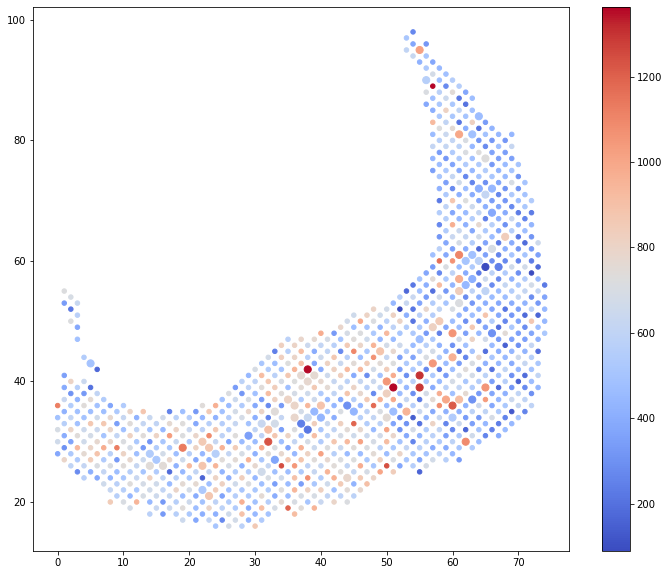

In [286]:
cort_l = [3,6,8,9]

fig = plt.figure(figsize=(12,10))
curr_plq_ind = np.intersect1d(np.hstack([row_ind[x] for x in cort_l]) , np.where(plq_bool == True)[0])
curr_norm_ind = np.intersect1d(np.hstack([row_ind[x] for x in cort_l]) , np.where(plq_bool == False)[0])

plt.scatter(rows[curr_norm_ind], cols[curr_norm_ind], s=20,c=genenorm_m[:,gene_ind], cmap='coolwarm')#, vmin = 0, vmax = 400)
plt.scatter(rows[curr_plq_ind], cols[curr_plq_ind], s=50, c=geneplq_m[:,gene_ind], cmap='coolwarm')#, vmin = 0, vmax = 400)
plt.colorbar()
#plt.legend()
plt.savefig('fig_dump/plaque-cortex-humanAPP.png', transparent=True)
plt.show()

In [131]:
sig_genes

Index(['Atp1b1', 'Zfyve9', 'Cplx1', 'Thy1', 'Pkm', 'Nefh', 'Pde6g', 'Nefm',
       'Nefl', 'Sub1', 'Lynx1', 'Pphln1', 'Gm10545', 'Ina'],
      dtype='object')

# Plaque micro-environment